In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tools.eval_measures import rmse

import seaborn as sns
sns.set_style('darkgrid')

from sklearn import preprocessing

import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_zillow_weekly = pd.read_csv("zillow_weekly_mediansale.csv")

In [3]:
df_ny = df_zillow_weekly[df_zillow_weekly.RegionName == 'New York, NY'].melt(id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'], var_name='Date', value_name = 'MedianSalesPrice')[['MedianSalesPrice', 'Date']]
df_sf = df_zillow_weekly[df_zillow_weekly.RegionName == 'San Francisco, CA'].melt(id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'], var_name='Date', value_name = 'MedianSalesPrice')[['MedianSalesPrice', 'Date']]
df_den = df_zillow_weekly[df_zillow_weekly.RegionName == 'Denver, CO'].melt(id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'], var_name='Date', value_name = 'MedianSalesPrice')[['MedianSalesPrice', 'Date']]
df_seat = df_zillow_weekly[df_zillow_weekly.RegionName == 'Seattle, WA'].melt(id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'], var_name='Date', value_name = 'MedianSalesPrice')[['MedianSalesPrice', 'Date']]

dfs = [df_ny, df_sf, df_den, df_seat]

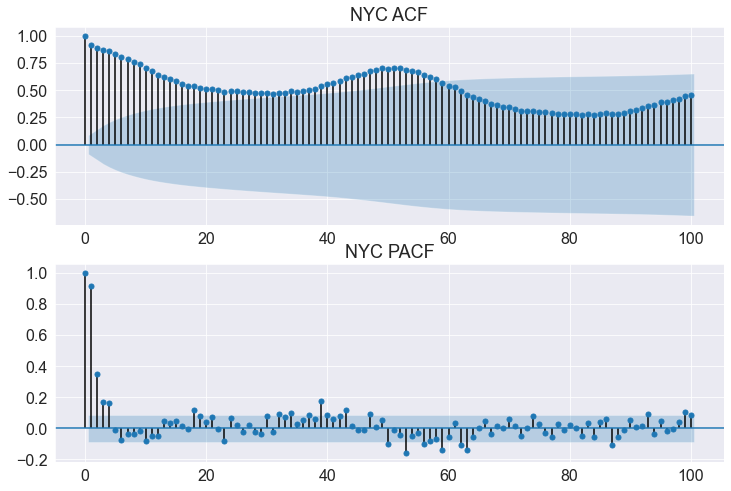

In [25]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_ny['MedianSalesPrice'].dropna(), lags=100, ax=ax1)
plt.title('NYC ACF', fontsize = 18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_ny['MedianSalesPrice'].dropna(), lags=100, ax=ax2)
plt.title('NYC PACF', fontsize = 18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


plt.show()

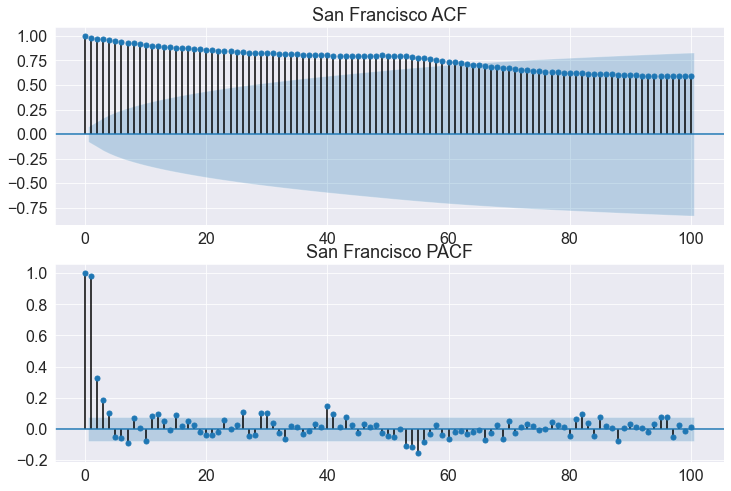

In [26]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_sf['MedianSalesPrice'].dropna(), lags=100, ax=ax1)
plt.title('San Francisco ACF', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_sf['MedianSalesPrice'].dropna(), lags=100, ax=ax2)
plt.title('San Francisco PACF', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

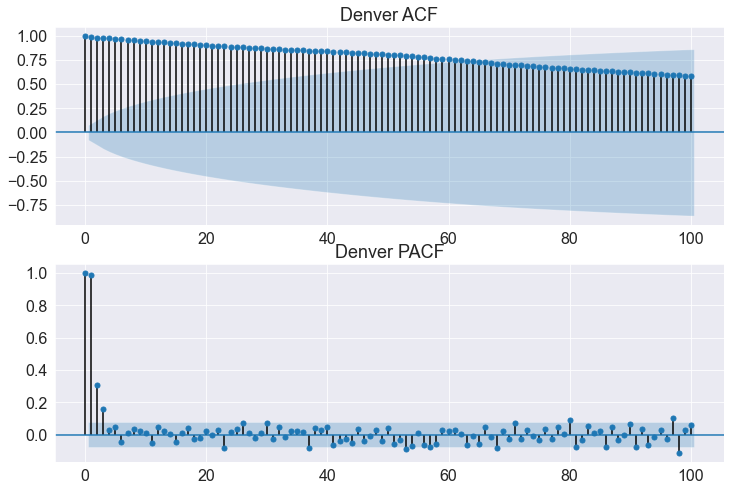

In [27]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_den['MedianSalesPrice'].dropna(), lags=100, ax=ax1)
plt.title('Denver ACF', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_den['MedianSalesPrice'].dropna(), lags=100, ax=ax2)
plt.title('Denver PACF', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

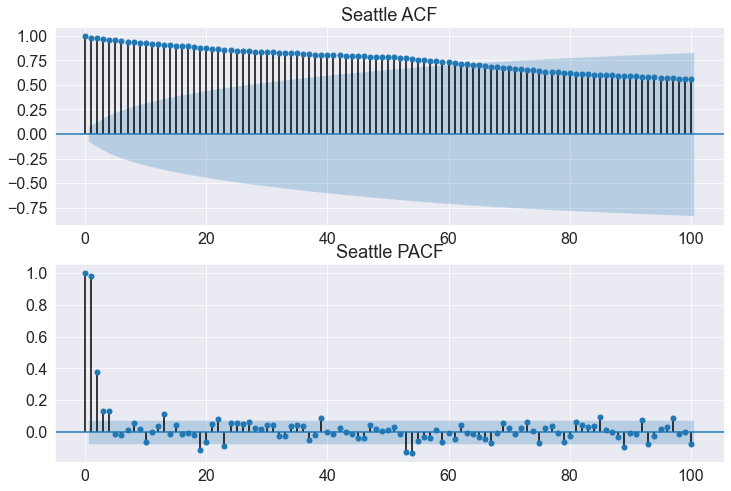

In [30]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_seat['MedianSalesPrice'].dropna(), lags=100, ax=ax1)
plt.title('Seattle ACF', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_seat['MedianSalesPrice'].dropna(), lags=100, ax=ax2)
plt.title('Seattle PACF', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [8]:
for i in range(len(dfs)):
    dfs[i].index = pd.to_datetime(dfs[i]['Date'])
    dfs[i] = dfs[i].drop(['Date'], axis = 1).dropna()
    
    dates = dfs[i].index
    columns = dfs[i].columns
    x = dfs[i].values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    dfs[i] = pd.DataFrame(x_scaled, columns = columns)
    dfs[i].index = dates

df_ny = dfs[0]
df_sf = dfs[1]
df_den = dfs[2]
df_seat = dfs[3]

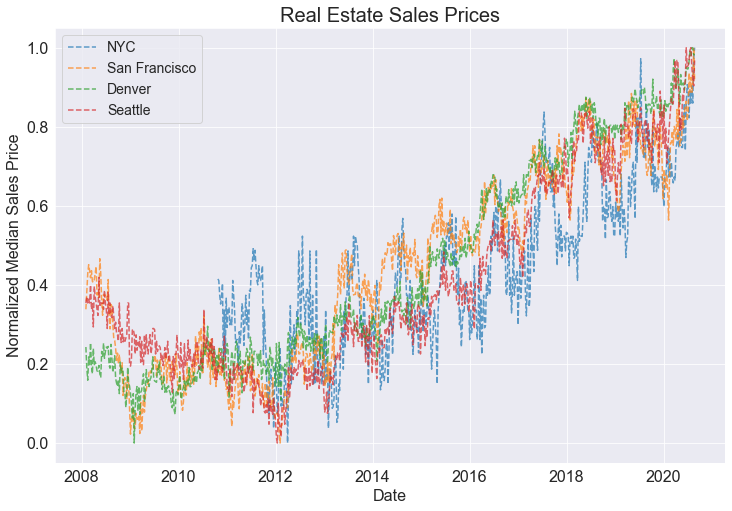

In [12]:
plt.figure(figsize = (12, 8))

plt.plot(df_ny, '--', label = 'NYC', alpha = 0.7)
plt.plot(df_sf, '--', label = 'San Francisco', alpha = 0.7)
plt.plot(df_den, '--', label = 'Denver', alpha = 0.7)
plt.plot(df_seat, '--', label = 'Seattle', alpha = 0.7)

plt.xticks(fontsize=16)
plt.xlabel('Date', fontsize = 16)
plt.yticks(fontsize=16)
plt.ylabel('Normalized Median Sales Price', fontsize = 16)
plt.title('Real Estate Sales Prices', fontsize = 20)
plt.legend(fontsize=14)


In [13]:
counter = 0

ny_data = []
sf_data = []
den_data = []
seat_data = []

rmses = []

shifts = 10

for df in dfs:  

    for i in range(1, 10): # Training Size
        for j in range(1, 9): # Time Steps
            for shift in range(1, shifts + 1): # Shifts 

                train = df[len(df)-52*i-j-shift:-j-shift]
                test = df[-j-shift:-shift]
                
                model = ARIMA(train, order=(4,1,0))
                model_fit = model.fit()

                fc, sd, ci = model_fit.forecast(len(test))
                
                test['ARIMA_Predictions'] = fc;

                arima_rmse_error = rmse(test['MedianSalesPrice'], test['ARIMA_Predictions'])
                
                rmses.append(arima_rmse_error)

                if counter == 0:
                    if shift == shifts:
                        ny_data.append(np.array(rmses).mean())
                        rmses = []
                
                if counter == 1:
                    if shift == shifts:
                        sf_data.append(np.array(rmses).mean())
                        rmses = []
                        
                if counter == 2:
                    if shift == shifts:
                        den_data.append(np.array(rmses).mean())
                        rmses = []
                        
                if counter == 3:
                    if shift == shifts:
                        seat_data.append(np.array(rmses).mean())
                        rmses = []
                        
    counter += 1

In [57]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:     D.MedianSalesPrice   No. Observations:                  467
Model:                 ARIMA(4, 1, 0)   Log Likelihood                 866.564
Method:                       css-mle   S.D. of innovations              0.038
Date:                Mon, 14 Dec 2020   AIC                          -1721.128
Time:                        14:40:00   BIC                          -1696.250
Sample:                    05-14-2011   HQIC                         -1711.337
                         - 04-18-2020                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0017      0.001      2.136      0.033       0.000       0.003
ar.L1.D.MedianSalesPrice    -0.5533      0.046    -11.983      0.000      -0.644      -0.463
ar.L2.D.MedianSalesPrice    -0.3048      0.052     -5.869      0.000      -0.407      -0.203
ar.L3.D.MedianSalesPrice    -0.2149      0.052     -4.146      0.000      -0.317      -0.113
ar.L4.D.MedianSalesPrice    -0.0731      0.046     -1.579      0.114      -0.164       0.018
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.4417           -1.6821j            1.7391           -0.2091
AR.2            0.4417           +1.6821j            1.7391            0.2091
AR.3           -1.9119           -0.9316j            2.1268           -0.4278
AR.4           -1.9119           +0.9316j            2.1268            0.4278
-----------------------------------------------------------------------------
"""

In [14]:
index = [1, 2, 3, 4, 5, 6, 7, 8, 9]
columns = ['Time Step = 1', 'Time Step = 2', 
           'Time Step = 3', 'Time Step = 4', 
           'Time Step = 5', 'Time Step = 6', 
           'Time Step = 7', 'Time Step = 8']

ny_data = pd.DataFrame(np.reshape(np.array(ny_data), (9, 8)), index = index, columns = columns)
sf_data = pd.DataFrame(np.reshape(np.array(sf_data), (9, 8)), index = index, columns = columns)
den_data = pd.DataFrame(np.reshape(np.array(den_data), (9, 8)), index = index, columns = columns)
seat_data = pd.DataFrame(np.reshape(np.array(seat_data), (9, 8)), index = index, columns = columns)

ny_data.index.name = 'Training Size (Years)'
sf_data.index.name = 'Training Size (Years)'
den_data.index.name = 'Training Size (Years)'
seat_data.index.name = 'Training Size (Years)'

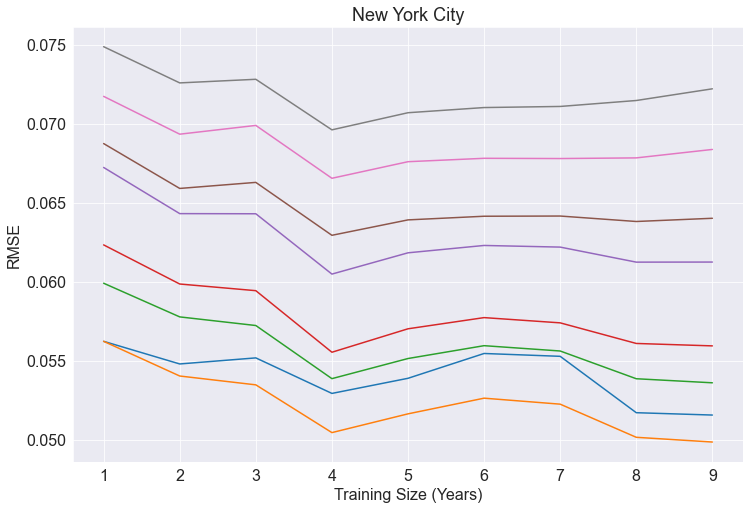

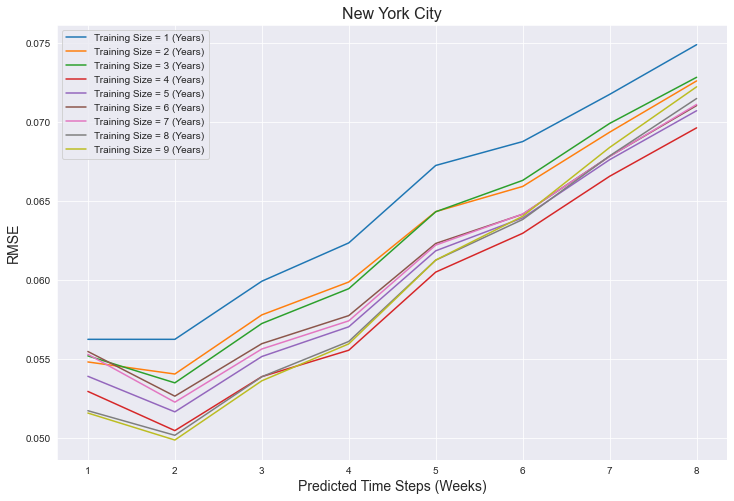

In [38]:
plt.figure(figsize = (12, 8))

for i in range(len(ny_data)-1):
    plt.plot(np.linspace(1, 9, 9), ny_data.T.iloc[i], label = 'Predicted {} (Weeks)'.format(ny_data.columns[i]))
    
plt.title('New York City', fontsize = 18)
plt.xlabel('Training Size (Years)', fontsize = 16);
plt.ylabel('RMSE', fontsize = 16); 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=14)

plt.figure(figsize = (12, 8))

for i in range(len(ny_data)):
    plt.plot(np.linspace(1, 8, 8), ny_data.iloc[i], label = 'Training Size = {} (Years)'.format(ny_data.index[i]))

plt.title('New York City', fontsize = 16)
plt.xlabel('Predicted Time Steps (Weeks)', fontsize = 14);
plt.ylabel('RMSE', fontsize = 14); 
plt.legend();


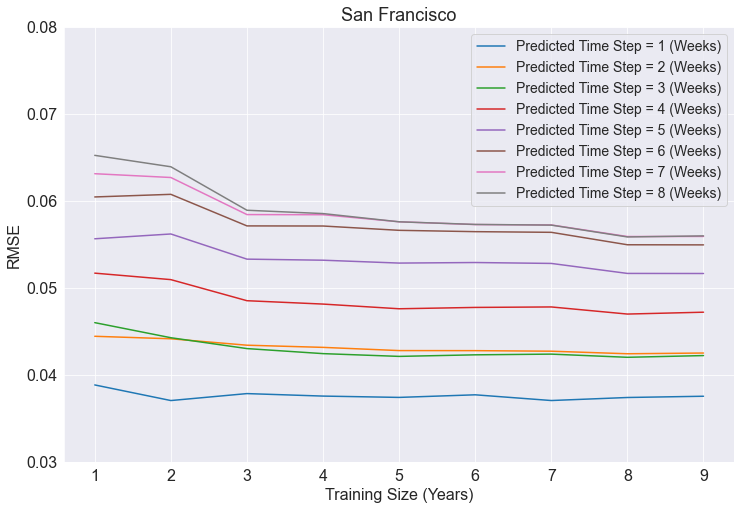

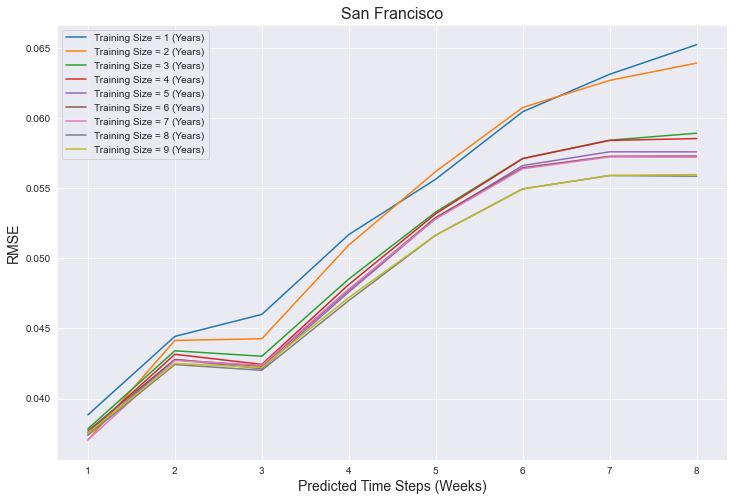

In [51]:
plt.figure(figsize = (12, 8))

for i in range(len(sf_data)-1):
    plt.plot(np.linspace(1, 9, 9), sf_data.T.iloc[i], label = 'Predicted {} (Weeks)'.format(sf_data.columns[i]))
    
plt.title('San Francisco', fontsize = 18)
plt.xlabel('Training Size (Years)', fontsize = 16);
plt.ylabel('RMSE', fontsize = 16); 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim([0.03, 0.08])
plt.legend(fontsize=14);

plt.figure(figsize = (12, 8))

for i in range(len(ny_data)):
    plt.plot(np.linspace(1, 8, 8), sf_data.iloc[i], label = 'Training Size = {} (Years)'.format(sf_data.index[i]))
    
plt.title('San Francisco', fontsize = 16)
plt.xlabel('Predicted Time Steps (Weeks)', fontsize = 14);
plt.ylabel('RMSE', fontsize = 14); 
plt.legend();

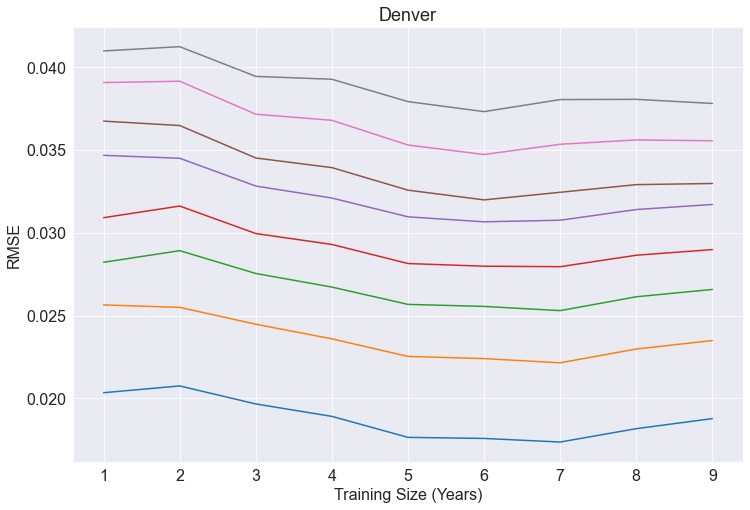

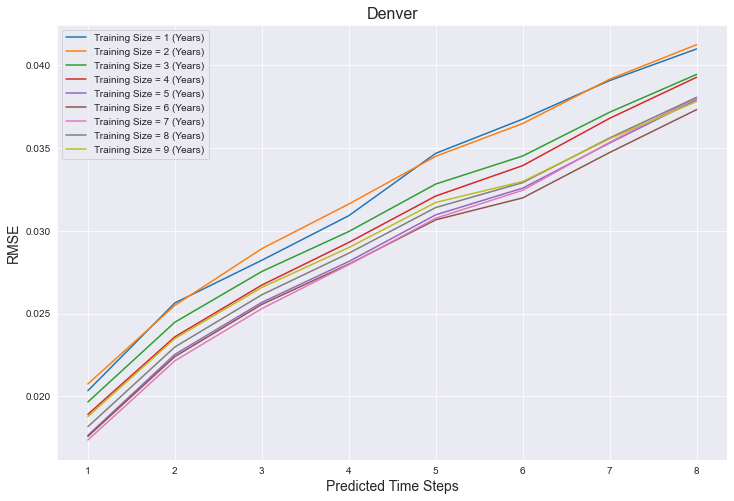

In [40]:
plt.figure(figsize = (12, 8))

for i in range(len(ny_data)-1):
    plt.plot(np.linspace(1, 9, 9), den_data.T.iloc[i], label = 'Predicted {} (Weeks)'.format(den_data.columns[i]))
    
plt.title('Denver', fontsize = 18)
plt.xlabel('Training Size (Years)', fontsize = 16);
plt.ylabel('RMSE', fontsize = 16); 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.figure(figsize = (12, 8))

for i in range(len(ny_data)):
    plt.plot(np.linspace(1, 8, 8), den_data.iloc[i], label = 'Training Size = {} (Years)'.format(den_data.index[i]))

plt.title('Denver', fontsize = 16)
plt.xlabel('Predicted Time Steps', fontsize = 14);
plt.ylabel('RMSE', fontsize = 14); 
plt.legend();

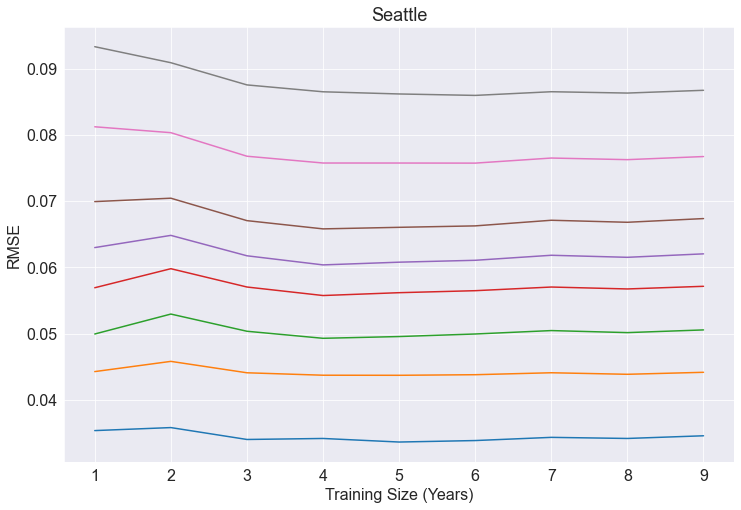

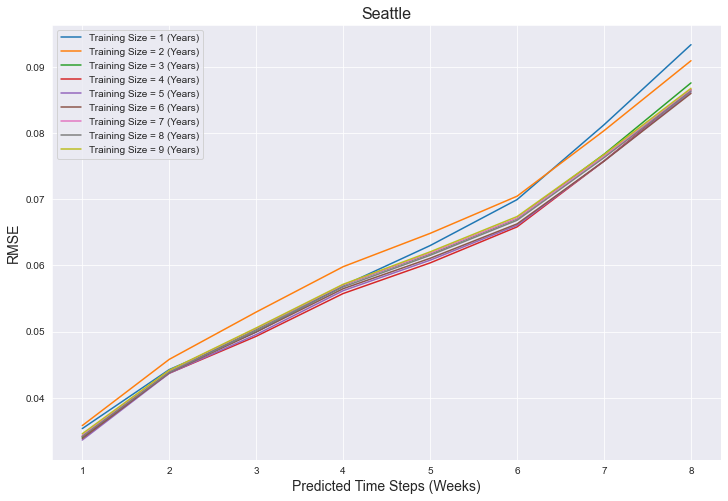

In [41]:
plt.figure(figsize = (12, 8))

for i in range(len(ny_data)-1):
    plt.plot(np.linspace(1, 9, 9), seat_data.T.iloc[i], label = 'Predicted {} (Weeks)'.format(seat_data.columns[i]))
    
plt.title('Seattle', fontsize = 18)
plt.xlabel('Training Size (Years)', fontsize = 16);
plt.ylabel('RMSE', fontsize = 16); 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.figure(figsize = (12, 8))

for i in range(len(ny_data)):
    plt.plot(np.linspace(1, 8, 8), seat_data.iloc[i], label = 'Training Size = {} (Years)'.format(seat_data.index[i]))
    
plt.title('Seattle', fontsize = 16)
plt.xlabel('Predicted Time Steps (Weeks)', fontsize = 14);
plt.ylabel('RMSE', fontsize = 14); 
plt.legend();

In [58]:
ny_data.mean().mean()

0.06103623581681409

In [20]:
sf_data.mean().mean()

0.05002990591493211

In [21]:
den_data.mean().mean()

0.029986689647235637

In [22]:
seat_data.mean().mean()

0.060043503969742056